In [1]:
import gensim
import subprocess
import re
import numpy as np
import time
import nltk
import os
import json
import collections
import time
import matplotlib.pyplot as plt
import itertools
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
nltk.download('stopwords')
nltk.download('punkt')

Using TensorFlow backend.
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kirov/.local/lib/python3.7/site-packages/tensorflow/python/fra

True

### Problema: Determinar la veracidad de tweets, utilizando clasificación
- Implementar un clasificador de post de tweets para validar su veracidad.
- Para esto se utilizará redes neuronales y el árbol de  propagación de los tweets.


In [2]:
#Image("/home/eprovidel/Text_Mining/Proyecto/modelos.png")

In [3]:
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

# Parte 1: Procesamiento de datos y funcionalidades

## Parte 1.1: Cargar tweets para generar datos de entrenamiento

In [4]:
words_not_in_model = list()
def computeDocumentAWE(docText, _model, _model_vocab, _emb_size):
    """
    Calcula el AWE del texto recibido en el parámetro docText.
    La variable docSum almacena la suma de los embeddings de cada
    palabra w en docText. Luego esta suma se divide por el total
    de n palabras consideradas.
    
    Se considero una palabra para el cálculo sólo si esta pertenece
    al vocabulario del modelo. Si no, no es considerada en la suma 
    ni tampoco en el calculo de n.
    """    
    docSum = np.zeros(_emb_size)
    n = 0
    
    ####
    ## AWE = 1/n * Sum w_embedding, para cada w en docText
    ####
    
    normalizedDocText = normalizarTexto(docText)
    
    for w in normalizedDocText:
        ## Se descartan palabras que no están en el modelo de embeddings (vocabulario)
        if w in _model_vocab:
            n = n + 1
            w_embedding = _model[w]
            docSum = docSum + w_embedding
        else:
            words_not_in_model.append(w)

    return docSum / n if n > 0 else docSum    

In [5]:
def normalizarTexto(docText):
    # En gensim.utils, pasa a minúsculas, descarta palabras muy grandes o muy pequeñas.
    return simple_preprocess(docText)

In [6]:
def parseTwitterTree(tree_file):
    tree_data = list()
    for line in tree_file:
        _, second_part = line.split('->')
        second_part = second_part.rstrip()
        second_part = second_part.replace("'", "\"")
        tree_data.append(json.loads(second_part))     
    return tree_data

In [7]:
### Obtener diccionario con todos los posts
all_posts = {}
all_text = {}
#for file in os.listdir('/home/kirov/dataset/post'):
for file in os.listdir('./post'):    
    if file.endswith(".json"):        
        try:        
            with open(os.path.join('./post', file), 'r') as f:
                tweet_id  = os.path.splitext(file)[0]
                tweet_dic = json.load(f)
                all_posts[tweet_id] = tweet_dic
                

        except:
            pass
        

### Obtener ids de tweets etiquetados
labels = {}
with open('label.txt') as label_f:
    for label_line in label_f:
        
        label, tweet_id = label_line.split(':')
        tweet_id = tweet_id.rstrip()
        labels[tweet_id] = label

print("Tweets etiquetados      : ", len(labels))        

seqs_lens = []
labeled_posts = {}
number_of_tweets = 0
number_of_retweets = 0
number_of_invalid_tweets = 0
no_in_data = 0
for tweet_id in labels.keys():
    try:
        if tweet_id in all_posts:
            tree_path = os.path.join('./tree', tweet_id + '.txt')
            with open(tree_path) as tree_file:
                tree_data = parseTwitterTree(tree_file)
                ### Remover retweets                
                first = tree_data[0]
                without_rt = list(filter(lambda t: t[1] != tweet_id, tree_data))
                number_of_retweets = number_of_retweets + (len(tree_data) - len(without_rt))
                only_valid = list(filter(lambda t: t[1] in all_posts, without_rt))
                number_of_invalid_tweets = number_of_invalid_tweets + (len(without_rt) - len(only_valid))
                seqs_lens.append(len(only_valid))
                labeled_posts[tweet_id] = (labels[tweet_id], [first] + only_valid)
                number_of_tweets = number_of_tweets + 1 
        else:
             no_in_data = no_in_data + 1 
        
    except Exception as e:
        print(e)             
        
        
print("no_in_data              : ", no_in_data) ## están etiquetados, pero no en los post
print("number_of_tweets        : ", number_of_tweets)        
print("all_posts               : ", len(all_posts))
print("number_of_retweets      : ", number_of_retweets) ## En árbol de propagación
print("number_of_invalid_tweets: ", number_of_invalid_tweets) ## En árbol de propagación


Tweets etiquetados      :  818
no_in_data              :  65
number_of_tweets        :  753
all_posts               :  21741
number_of_retweets      :  297301
number_of_invalid_tweets:  6432


**Importante:** Importan sólo los datos etiquetados que se conocen y que no son retweets de cada árbol de progación.

## Parte 1.2: Aplicar AWE a cada tweet del arbol

In [8]:
## Cada palabra tiene un embedding que viene del modelo
## Se calcula AWE para cada post del árbol de propagación (lista de propagación que el primer elemento es el tweet original)
def computeTreeAWE(tree, _model, _model_vocab, _emb_size):
    return list(map(lambda t: [t[0], computeDocumentAWE(all_posts[t[1]]['text'],
                                                        _model, _model_vocab, _emb_size), t[2]], tree))

[17 19 33 23 28 32 22 22 22 22 16 17 15 18 22 15 19 16 21 11  9  8 10 14
  7  9  6  7  8  7 11  6  7  5  5 10  2  3  5  5  1  7  3  7  3  1  3  7
  4  5  2  3  5  1  1  4  1  4  5  0  3  0  1  4  2  3  4  2  1  2  1  1
  4  2  2  4  1  1  5  1  2  2  1  1  1  3  3  0  3  1  1  2  1  2  2  0
  1  1  1  1  0  0  1  0  1  1  0  1  2  1  1  0  0  1  0  1  0  1  0  0
  0  1  1  1  2  0  0  1  0  2  1  1  0  0  1  1  0  0  1  0  0  0  0  0
  1  0  1  0  1  0  0  0  0  0  1  1  0  0  2  1  0  0  1  1  1  0  0  0
  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0
  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  1  0  0  0  1  1  0  0  1  0  0  0  0  0  0  1
  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

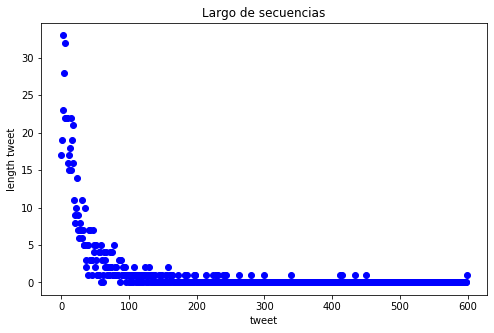

In [9]:
# Categorias: true, false, unverified, non-rumor
categories = ['true', 'false', 'unverified', 'non-rumor']
num_categories = len(categories)

#entrega un vector one-hot de la categoria, de largo 4 (por el número de categorias)
def to_category_vector(category):
    vector = np.zeros(len(categories)).astype(np.float32)
    
    for i in range(len(categories)):
        if categories[i] == category:
            vector[i] = 1.0
            break
    
    return vector

#La red neuronal necesita un tamaño fijo para la secuencia (datos de entrada)
#¿Que largo de secuencia utilizar?
counts = np.bincount(seqs_lens) ## seqs_len sólo de los 753
print(counts)
mode_seq_len = np.argmax(counts)
mean_seq_len = int(np.mean(seqs_lens))
min__seq_len = min(seqs_lens)
max__seq_len = max(seqs_lens) 
## luego se hace padding

print("seqs_lens   : ", seqs_lens)
print("min__seq_len: ", min__seq_len)
print("max__seq_len: ", max__seq_len)
print("mean_seq_len: ", mean_seq_len)
print("mode_seq_len: ", mode_seq_len )

plt.close('all')
plt.figure(figsize=(8,5))
plt.plot(counts,'bo')
plt.title("Largo de secuencias")
plt.xlabel("tweet")
plt.ylabel("length tweet")
plt.savefig('/home/kirov/plots/plt_largoSecuenciasGRU')

tree_max_num_seq = mean_seq_len

In [10]:
## padding al final, con empty
def padAWE(empty, max_num, seq):
    from itertools import repeat
    seq.extend(repeat(empty, max_num - len(seq)))
    return seq

In [11]:
## 
def generate_w2v_variant(_model, _model_vocab, _emb_size):
    
    empty_awe = np.zeros(_emb_size)
    ## Calcula AWE de cada árbol
    labeled_posts_awe = { k: (v[0], computeTreeAWE(v[1], _model, _model_vocab, _emb_size)) for k, v in labeled_posts.items() }
    ## Realiza padding a las secuencias
    padded_labeled_posts_awe = {k: (v[0], padAWE(empty_awe, tree_max_num_seq, v[1])) for k, v in labeled_posts_awe.items()}

    #Genera los datos X e Y para alimentar el modelo de red neuronal
    #Inicialmente con ceros y con la forma adecuada.
    X = np.zeros(shape=(number_of_tweets, tree_max_num_seq, _emb_size)).astype(np.float32)
    Y = np.zeros(shape=(number_of_tweets, num_categories)).astype(np.float32)

    # Asigna al vector X los datos correspondientes
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        for jdx, tweet_d in enumerate(tweet_data[1]):
            ### tweet_d = [uid, tweet_awe, time]
            if jdx == tree_max_num_seq:
                break            
            else:            
                X[idx, jdx, :] = tweet_d[1]

    # Asigna al vector Y los datos correspondientes            
    for idx, (tweet_id, tweet_data) in enumerate(list(padded_labeled_posts_awe.items())):
        Y[idx, :] = to_category_vector(tweet_data[0])

    print(np.shape(X))
    print(np.shape(Y))
    return X, Y

## Parte 1.3: Modelo BiGRU

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, GRU, Bidirectional, Conv1D, Flatten, MaxPooling1D


### tensorflow OMP: Error #15
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'



def create_model_BI_GRU(
        _emb_size,
        _num_categories,
        _units = 200,
        _dropout = 0.3):
    
    model = Sequential()
    model.add(Bidirectional(GRU(_units, input_shape=(tree_max_num_seq, _emb_size), return_sequences=False)))
    model.add(Dropout(_dropout))
    model.add(Dense(_num_categories))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    



## Parte 1.4: Funciones para graficar

In [13]:
def graphic_data(dataX, dataY, labels, title, x_label, y_label, x_min, y_min, x_max, y_max=0):
    plt.close('all') 
    plt.title(title)
    for d in dataY:
        plt.ylim(y_min,y_max)
        plt.xlim(x_min,x_max)
        plt.plot(d)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(dataX)
    plt.legend(labels, loc='upper right')
    plt.savefig('/home/kirov/plots/plt_grapicDataBiGRU')
    plt.show()

In [14]:
#ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/home/kirov/plots/plt_matrizBiGRU')

In [15]:
def plot_conf_matrix(y_true, y_pred, _title):
    y_t = y_true.argmax(1)#Yw2v50_full.argmax(1)
    y_p = y_pred.argmax(1)#Yw2v50_predict.argmax(1)
    conf_matrix = confusion_matrix(y_t, y_p)
    class_names = ['true', 'false', 'unverified', 'non-rumor']
    # Plot confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False,
                      title=_title,cmap=plt.cm.Greens) 

## Parte 1.5: Entrenamiento y Pruebas

In [16]:
epochs = 50 #200
units_final = [128,256] #[8,16, 32, 64, 128, 256, 512, 1024]

In [17]:
#dummy_model = create_model_LSTM(10, 128)
#dummy_model = create_model_GRU(10,10,128)
#dummy_model.summary()

In [18]:
def perform_kfold_validation(X, Y, _emb_size, k = 5, _verbose = 0):
    seed = 7
    results_score = []
    results_acc   = []
    results_time  = []
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    y_pred = []

    for j, (train_idx, test_idx) in enumerate(kfold.split(X, Y.argmax(1))):
        print('\nFold ',j)
        print("\nlen train index: %s" % len(train_idx))       
        print("len test index: %s" % len(test_idx))
        X_train_cv = X[train_idx]
        Y_train_cv = Y[train_idx]
        X_test_cv  = X[test_idx]
        Y_test_cv  = Y[test_idx]
        
        #crear modelo GRU
        
        model = create_model_BI_GRU(_emb_size,num_categories)
     
        start_time = time.time()
        model.fit(X_train_cv, Y_train_cv, batch_size=128, epochs=200, verbose= _verbose)     ## entrenamos
        score, acc = model.evaluate(X_test_cv, Y_test_cv, batch_size=128,verbose= _verbose) ## evaluamos /acc: accuracy
        end_time = time.time()

        print('Score: %1.4f' % score)
        print('Accuracy: %1.4f' % acc)  
        print('time: %1.4f' % (end_time - start_time))
        results_score.append(score)
        results_acc.append(acc)
        results_time.append((end_time - start_time))
    
    return results_score, results_acc, results_time

In [27]:
### https://datascience.stackexchange.com/questions/20413/clarification-on-the-keras-recurrent-unit-cell
def perform_final_validation(X, Y, X_validate, Y_validate, _emb_size, units=[8,16, 32, 64, 128, 200], _epochs=200, _verbose=1):
    h_units_score = []
    h_units_acc   = []
    history = []
    all_models = []
    for unit_size in (units): #[8,16, 32, 64, 128, 200, 512, 1024]
        print("########################")
        print("## UNIT SIZE ", unit_size)
        
        #crear modelo final GRU
        
        final_model = create_model_BI_GRU(_emb_size,num_categories, _units = unit_size)
        
        #final_model.summary()
        
        history.append(final_model.fit(X, Y, batch_size=128, epochs=_epochs, verbose=_verbose))
        score, acc = final_model.evaluate(X_validate, Y_validate, batch_size=128)
        h_units_score.append(score)
        h_units_acc.append(acc)
        all_models.append(final_model)
    return h_units_score, h_units_acc,history, all_models

## Parte 2: Modelo LSTM

### Modelo word2vec específico, LSTM

### Creando los vectores
Se utilizan todos los tweets etiquetados como el universo de documentos, para crear el modelo de embedding w2v

In [20]:
# build vocabulary and train model
w2v50_emb_size = 50
WINDOW = 5
W2V_EPOCHS = 50
BATCH_SIZE = 128

documents = []
for k, v in labeled_posts.items():
    for t in v[1]:
        #print(t[1]) ## sera porque algunos text estan vacios????
        # Dejar todo en lowercase
        documents.append(simple_preprocess(all_posts[t[1]]['text']))

In [21]:

w2v50_model = gensim.models.word2vec.Word2Vec(
 documents,
 size=w2v50_emb_size,
 window=WINDOW,
 min_count=2,
 workers=4,
 iter=W2V_EPOCHS
)

#Train model
w2v50_model.train(documents, total_examples=len(documents), epochs=w2v50_model.epochs)

(14800159, 18536800)

In [22]:
w2v50_model_vocab = w2v50_model.wv.vocab

In [23]:
Xw2v50_full, Yw2v50_full = generate_w2v_variant(w2v50_model, w2v50_model_vocab, w2v50_emb_size)
Xw2v50, X_1w2v50, Yw2v50, Y_1w2v50 = train_test_split(Xw2v50_full, Yw2v50_full, test_size=0.15)
perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size)
#perform_final_validation(Xw2v50, Yw2v50, X_1, Y_1, w2v50_emb_size) #X_1 y Y_1 Es el tamaño del set de testing
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)

/home/kirov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(753, 36, 50)
(753, 4)

Fold  0

len train index: 512
len test index: 128

Score: 2.2859
Accuracy: 0.7109
time: 419.5732

Fold  1

len train index: 512
len test index: 128
Score: 2.2502
Accuracy: 0.6953
time: 432.1060

Fold  2

len train index: 512
len test index: 128
Score: 2.2461
Accuracy: 0.6875
time: 454.9510

Fold  3

len train index: 512
len test index: 128
Score: 2.2391
Accuracy: 0.6719
time: 428.9590

Fold  4

len train index: 512
len test index: 128
Score: 2.5351
Accuracy: 0.6484
time: 448.6688
########################
## UNIT SIZE  8


TypeError: create_model_BI_GRU() got an unexpected keyword argument 'units'

In [29]:
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)

########################
## UNIT SIZE  8
Epoch 1/200
640/640 [==============================] - 2s 3ms/step - loss: 1.4833 - accuracy: 0.2500
Epoch 2/200
640/640 [==============================] - 0s 599us/step - loss: 1.4527 - accuracy: 0.2625
Epoch 3/200
640/640 [==============================] - 0s 712us/step - loss: 1.4329 - accuracy: 0.2937
Epoch 4/200
640/640 [==============================] - 1s 924us/step - loss: 1.3973 - accuracy: 0.3187
Epoch 5/200
640/640 [==============================] - 0s 728us/step - loss: 1.3576 - accuracy: 0.3297
Epoch 6/200
640/640 [==============================] - 0s 663us/step - loss: 1.3240 - accuracy: 0.3672
Epoch 7/200
640/640 [==============================] - 0s 777us/step - loss: 1.3142 - accuracy: 0.3750
Epoch 8/200
640/640 [==============================] - 1s 839us/step - loss: 1.3013 - accuracy: 0.3953
Epoch 9/200
640/640 [==============================] - 1s 913us/step - loss: 1.2645 - accuracy: 0.4078
Epoch 10/200
640/640 [============

640/640 [==============================] - 1s 1ms/step - loss: 0.5142 - accuracy: 0.8156
Epoch 80/200
640/640 [==============================] - 0s 502us/step - loss: 0.5139 - accuracy: 0.8156
Epoch 81/200
640/640 [==============================] - 0s 624us/step - loss: 0.4912 - accuracy: 0.8297
Epoch 82/200
640/640 [==============================] - 0s 557us/step - loss: 0.4894 - accuracy: 0.8266
Epoch 83/200
640/640 [==============================] - 0s 559us/step - loss: 0.4787 - accuracy: 0.8188
Epoch 84/200
640/640 [==============================] - 0s 648us/step - loss: 0.5021 - accuracy: 0.8328
Epoch 85/200
640/640 [==============================] - 0s 631us/step - loss: 0.4642 - accuracy: 0.8375
Epoch 86/200
640/640 [==============================] - 1s 1ms/step - loss: 0.4822 - accuracy: 0.8250
Epoch 87/200
640/640 [==============================] - 0s 689us/step - loss: 0.4647 - accuracy: 0.8375
Epoch 88/200
640/640 [==============================] - 0s 572us/step - loss: 0.4

640/640 [==============================] - 1s 805us/step - loss: 0.2448 - accuracy: 0.9172
Epoch 158/200
640/640 [==============================] - 0s 566us/step - loss: 0.2263 - accuracy: 0.9297
Epoch 159/200
640/640 [==============================] - 0s 760us/step - loss: 0.2377 - accuracy: 0.9297
Epoch 160/200
640/640 [==============================] - 0s 660us/step - loss: 0.2147 - accuracy: 0.9344
Epoch 161/200
640/640 [==============================] - 0s 618us/step - loss: 0.2345 - accuracy: 0.9266
Epoch 162/200
640/640 [==============================] - 1s 830us/step - loss: 0.2295 - accuracy: 0.9297
Epoch 163/200
640/640 [==============================] - 0s 661us/step - loss: 0.2278 - accuracy: 0.9281
Epoch 164/200
640/640 [==============================] - 1s 819us/step - loss: 0.2305 - accuracy: 0.9234
Epoch 165/200
640/640 [==============================] - 0s 684us/step - loss: 0.2109 - accuracy: 0.9375
Epoch 166/200
640/640 [==============================] - 1s 1ms/step 

640/640 [==============================] - 0s 598us/step - loss: 0.5676 - accuracy: 0.7969
Epoch 35/200
640/640 [==============================] - 0s 729us/step - loss: 0.5491 - accuracy: 0.8188
Epoch 36/200
640/640 [==============================] - 1s 789us/step - loss: 0.5519 - accuracy: 0.8094
Epoch 37/200
640/640 [==============================] - 1s 925us/step - loss: 0.5438 - accuracy: 0.8172
Epoch 38/200
640/640 [==============================] - 1s 830us/step - loss: 0.5314 - accuracy: 0.8031
Epoch 39/200
640/640 [==============================] - 1s 859us/step - loss: 0.5141 - accuracy: 0.8031
Epoch 40/200
640/640 [==============================] - 0s 720us/step - loss: 0.5016 - accuracy: 0.8234
Epoch 41/200
640/640 [==============================] - 0s 710us/step - loss: 0.5033 - accuracy: 0.8328
Epoch 42/200
640/640 [==============================] - 1s 792us/step - loss: 0.4719 - accuracy: 0.8453
Epoch 43/200
640/640 [==============================] - 1s 873us/step - loss:

Epoch 113/200
640/640 [==============================] - 0s 754us/step - loss: 0.1602 - accuracy: 0.9656
Epoch 114/200
640/640 [==============================] - 1s 826us/step - loss: 0.1466 - accuracy: 0.9656
Epoch 115/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1567 - accuracy: 0.9531
Epoch 116/200
640/640 [==============================] - 1s 788us/step - loss: 0.1507 - accuracy: 0.9594
Epoch 117/200
640/640 [==============================] - 1s 936us/step - loss: 0.1420 - accuracy: 0.9625
Epoch 118/200
640/640 [==============================] - 0s 701us/step - loss: 0.1439 - accuracy: 0.9609
Epoch 119/200
640/640 [==============================] - 1s 916us/step - loss: 0.1321 - accuracy: 0.9656
Epoch 120/200
640/640 [==============================] - 0s 670us/step - loss: 0.1371 - accuracy: 0.9734
Epoch 121/200
640/640 [==============================] - 0s 714us/step - loss: 0.1389 - accuracy: 0.9672
Epoch 122/200
640/640 [==============================] - 

640/640 [==============================] - 1s 981us/step - loss: 0.0619 - accuracy: 0.9875
Epoch 191/200
640/640 [==============================] - 1s 889us/step - loss: 0.0640 - accuracy: 0.9875
Epoch 192/200
640/640 [==============================] - 0s 668us/step - loss: 0.0678 - accuracy: 0.9859
Epoch 193/200
640/640 [==============================] - 1s 878us/step - loss: 0.0608 - accuracy: 0.9891
Epoch 194/200
640/640 [==============================] - 0s 692us/step - loss: 0.0695 - accuracy: 0.9844
Epoch 195/200
640/640 [==============================] - 1s 932us/step - loss: 0.0711 - accuracy: 0.9828
Epoch 196/200
640/640 [==============================] - 0s 668us/step - loss: 0.0599 - accuracy: 0.9844
Epoch 197/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0619 - accuracy: 0.9906
Epoch 198/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0590 - accuracy: 0.9891
Epoch 199/200
640/640 [==============================] - 1s 857us/step - 

640/640 [==============================] - 1s 1ms/step - loss: 0.1101 - accuracy: 0.9734
Epoch 69/200
640/640 [==============================] - 0s 721us/step - loss: 0.1209 - accuracy: 0.9766
Epoch 70/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1157 - accuracy: 0.9766
Epoch 71/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1217 - accuracy: 0.9766
Epoch 72/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1082 - accuracy: 0.9750
Epoch 73/200
640/640 [==============================] - 1s 843us/step - loss: 0.1018 - accuracy: 0.9828
Epoch 74/200
640/640 [==============================] - 1s 857us/step - loss: 0.0994 - accuracy: 0.9797
Epoch 75/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1094 - accuracy: 0.9781
Epoch 76/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0970 - accuracy: 0.9766
Epoch 77/200
640/640 [==============================] - 1s 936us/step - loss: 0.0908 - ac

640/640 [==============================] - 1s 1ms/step - loss: 0.0100 - accuracy: 1.0000
Epoch 148/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0106 - accuracy: 1.0000
Epoch 149/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0119 - accuracy: 1.0000
Epoch 150/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0102 - accuracy: 0.9984
Epoch 151/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0096 - accuracy: 1.0000
Epoch 152/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0099 - accuracy: 1.0000
Epoch 153/200
640/640 [==============================] - 0s 748us/step - loss: 0.0077 - accuracy: 1.0000
Epoch 154/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 155/200
640/640 [==============================] - 1s 798us/step - loss: 0.0105 - accuracy: 0.9984
Epoch 156/200
640/640 [==============================] - 1s 957us/step - loss: 0.00

640/640 [==============================] - 1s 2ms/step - loss: 0.3461 - accuracy: 0.8906
Epoch 26/200
640/640 [==============================] - 1s 1ms/step - loss: 0.3326 - accuracy: 0.8922
Epoch 27/200
640/640 [==============================] - 1s 1ms/step - loss: 0.3102 - accuracy: 0.8938
Epoch 28/200
640/640 [==============================] - 1s 1ms/step - loss: 0.2804 - accuracy: 0.9078
Epoch 29/200
640/640 [==============================] - 1s 1ms/step - loss: 0.2814 - accuracy: 0.9187
Epoch 30/200
640/640 [==============================] - 1s 1ms/step - loss: 0.2566 - accuracy: 0.9156
Epoch 31/200
640/640 [==============================] - 1s 1ms/step - loss: 0.2421 - accuracy: 0.9297
Epoch 32/200
640/640 [==============================] - 1s 1ms/step - loss: 0.2271 - accuracy: 0.9312
Epoch 33/200
640/640 [==============================] - 1s 2ms/step - loss: 0.2104 - accuracy: 0.9344
Epoch 34/200
640/640 [==============================] - 1s 2ms/step - loss: 0.2007 - accuracy: 

640/640 [==============================] - 1s 1ms/step - loss: 0.1021 - accuracy: 0.9656
Epoch 106/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0951 - accuracy: 0.9656
Epoch 107/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0692 - accuracy: 0.9797
Epoch 108/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0605 - accuracy: 0.9844
Epoch 109/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0407 - accuracy: 0.9922
Epoch 110/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0360 - accuracy: 0.9937
Epoch 111/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0364 - accuracy: 0.9937
Epoch 112/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0291 - accuracy: 0.9969
Epoch 113/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0232 - accuracy: 0.9984
Epoch 114/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0231 - a

640/640 [==============================] - 1s 1ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 185/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0073 - accuracy: 0.9984
Epoch 186/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0091 - accuracy: 0.9984
Epoch 187/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0069 - accuracy: 0.9984
Epoch 188/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 189/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 190/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 191/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 192/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 193/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0047 - a

640/640 [==============================] - 2s 3ms/step - loss: 0.0235 - accuracy: 0.9953
Epoch 64/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0218 - accuracy: 0.9984
Epoch 65/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0199 - accuracy: 0.9953
Epoch 66/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0196 - accuracy: 0.9984
Epoch 67/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0197 - accuracy: 0.9937
Epoch 68/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0180 - accuracy: 0.9969
Epoch 69/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0174 - accuracy: 0.9969
Epoch 70/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0172 - accuracy: 0.9969
Epoch 71/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0189 - accuracy: 0.9953
Epoch 72/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0142 - accuracy: 

640/640 [==============================] - 2s 3ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 144/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0056 - accuracy: 0.9984
Epoch 145/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0054 - accuracy: 0.9984
Epoch 146/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 147/200
640/640 [==============================] - 2s 2ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 148/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0060 - accuracy: 0.9984
Epoch 149/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0068 - accuracy: 0.9984
Epoch 150/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0050 - accuracy: 0.9984
Epoch 151/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 152/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0047 - a

Epoch 22/200
640/640 [==============================] - 3s 5ms/step - loss: 0.1377 - accuracy: 0.9594
Epoch 23/200
640/640 [==============================] - 3s 5ms/step - loss: 0.1331 - accuracy: 0.9625
Epoch 24/200
640/640 [==============================] - 3s 5ms/step - loss: 0.1161 - accuracy: 0.9672
Epoch 25/200
640/640 [==============================] - 3s 5ms/step - loss: 0.1083 - accuracy: 0.9672
Epoch 26/200
640/640 [==============================] - 3s 5ms/step - loss: 0.1048 - accuracy: 0.9750
Epoch 27/200
640/640 [==============================] - 3s 5ms/step - loss: 0.0972 - accuracy: 0.9766
Epoch 28/200
640/640 [==============================] - 4s 6ms/step - loss: 0.0909 - accuracy: 0.9766
Epoch 29/200
640/640 [==============================] - 3s 5ms/step - loss: 0.0873 - accuracy: 0.9797
Epoch 30/200
640/640 [==============================] - 3s 5ms/step - loss: 0.0870 - accuracy: 0.9734
Epoch 31/200
640/640 [==============================] - 3s 5ms/step - loss: 0.0788

640/640 [==============================] - 3s 5ms/step - loss: 9.4865e-04 - accuracy: 1.0000
Epoch 103/200
640/640 [==============================] - 3s 4ms/step - loss: 8.8567e-04 - accuracy: 1.0000
Epoch 104/200
640/640 [==============================] - 3s 5ms/step - loss: 8.7429e-04 - accuracy: 1.0000
Epoch 105/200
640/640 [==============================] - 3s 5ms/step - loss: 7.4611e-04 - accuracy: 1.0000
Epoch 106/200
640/640 [==============================] - 3s 5ms/step - loss: 7.7853e-04 - accuracy: 1.0000
Epoch 107/200
640/640 [==============================] - 3s 5ms/step - loss: 7.6306e-04 - accuracy: 1.0000
Epoch 108/200
640/640 [==============================] - 3s 4ms/step - loss: 8.4935e-04 - accuracy: 1.0000
Epoch 109/200
640/640 [==============================] - 2s 3ms/step - loss: 6.4987e-04 - accuracy: 1.0000
Epoch 110/200
640/640 [==============================] - 3s 5ms/step - loss: 6.0231e-04 - accuracy: 1.0000
Epoch 111/200
640/640 [============================

640/640 [==============================] - 3s 5ms/step - loss: 1.6570e-04 - accuracy: 1.0000
Epoch 179/200
640/640 [==============================] - 3s 4ms/step - loss: 2.0063e-04 - accuracy: 1.0000
Epoch 180/200
640/640 [==============================] - 2s 3ms/step - loss: 1.7716e-04 - accuracy: 1.0000
Epoch 181/200
640/640 [==============================] - 2s 3ms/step - loss: 1.6294e-04 - accuracy: 1.0000
Epoch 182/200
640/640 [==============================] - 2s 3ms/step - loss: 1.7037e-04 - accuracy: 1.0000
Epoch 183/200
640/640 [==============================] - 2s 3ms/step - loss: 1.6659e-04 - accuracy: 1.0000
Epoch 184/200
640/640 [==============================] - 2s 3ms/step - loss: 1.5786e-04 - accuracy: 1.0000
Epoch 185/200
640/640 [==============================] - 2s 3ms/step - loss: 1.5873e-04 - accuracy: 1.0000
Epoch 186/200
640/640 [==============================] - 3s 5ms/step - loss: 1.2861e-04 - accuracy: 1.0000
Epoch 187/200
640/640 [============================

([0.6336259245872498,
  0.6807644367218018,
  1.182021975517273,
  1.8178870677947998,
  1.3870501518249512,
  1.8636428117752075],
 [0.8141592741012573,
  0.8053097128868103,
  0.752212405204773,
  0.752212405204773,
  0.8053097128868103,
  0.7433628439903259],
  <keras.engine.sequential.Sequential at 0x7f73c6f5f6d0>])

In [30]:
print(np.sum(Yw2v50_full, axis=0)) 

[188. 180. 180. 205.]


In [31]:
#test
print(X_1w2v50.shape)
print(Y_1w2v50.shape)

(113, 36, 50)
(113, 4)


In [32]:
#train
print(Xw2v50.shape)
print(Yw2v50.shape)

(640, 36, 50)
(640, 4)


#### K-Folds w2v50, GRU

In [33]:
result_score_w2v50 = []
result_acc_w2v50   = []
resultTime_w2v50   = []

result_score_w2v50, result_acc_w2v50, resultTime_w2v50 =  perform_kfold_validation(Xw2v50, Yw2v50, w2v50_emb_size, k=5)


Fold  0

len train index: 512
len test index: 128
Score: 1.8459
Accuracy: 0.6641
time: 359.2432

Fold  1

len train index: 512
len test index: 128
Score: 1.8294
Accuracy: 0.7266
time: 348.6704

Fold  2

len train index: 512
len test index: 128
Score: 1.9942
Accuracy: 0.7109
time: 391.2645

Fold  3

len train index: 512
len test index: 128
Score: 2.3188
Accuracy: 0.6719
time: 392.3015

Fold  4

len train index: 512
len test index: 128
Score: 2.4332
Accuracy: 0.6250
time: 389.0262


#### Parte  Gráficos: K-Fold w2v50, GRU

In [34]:
data = []
data.append(result_acc_w2v50)
print(data)

[[0.6640625, 0.7265625, 0.7109375, 0.671875, 0.625]]


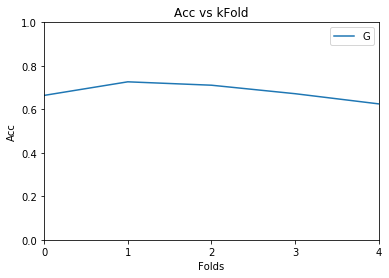

In [35]:
graphic_data([0,1,2,3,4],data,("GRU w2v50"),'Acc vs kFold', 'Folds', 'Acc',0,0,4,1)

#### Parte Validación: variando valor de units, w2v50, GRU

In [36]:
acc_final_w2v50 = []
score_final_w2v50 = []
history_final_w2v50 = []
models_w2v50 = []
perform_final_validation(Xw2v50, Yw2v50, X_1w2v50, Y_1w2v50, w2v50_emb_size)
score_final_w2v50,acc_final_w2v50,history_final_w2v50,models_w2v50 = perform_final_validation(Xw2v50, Yw2v50,
                                                                                X_1w2v50, Y_1w2v50, w2v50_emb_size,
                                                                                              units_final,epochs,0)

########################
## UNIT SIZE  8
Epoch 1/200
640/640 [==============================] - 2s 3ms/step - loss: 1.4983 - accuracy: 0.2172
Epoch 2/200
640/640 [==============================] - 0s 556us/step - loss: 1.4495 - accuracy: 0.2594
Epoch 3/200
640/640 [==============================] - 1s 853us/step - loss: 1.4362 - accuracy: 0.2641
Epoch 4/200
640/640 [==============================] - 0s 487us/step - loss: 1.4148 - accuracy: 0.2891
Epoch 5/200
640/640 [==============================] - 0s 604us/step - loss: 1.3918 - accuracy: 0.2937
Epoch 6/200
640/640 [==============================] - 0s 548us/step - loss: 1.3617 - accuracy: 0.3328
Epoch 7/200
640/640 [==============================] - 0s 715us/step - loss: 1.3297 - accuracy: 0.3313
Epoch 8/200
640/640 [==============================] - 0s 502us/step - loss: 1.3155 - accuracy: 0.3625
Epoch 9/200
640/640 [==============================] - 0s 774us/step - loss: 1.3018 - accuracy: 0.3734
Epoch 10/200
640/640 [============

640/640 [==============================] - 0s 781us/step - loss: 0.5579 - accuracy: 0.8000
Epoch 79/200
640/640 [==============================] - 0s 495us/step - loss: 0.5361 - accuracy: 0.8125
Epoch 80/200
640/640 [==============================] - 0s 600us/step - loss: 0.5478 - accuracy: 0.8031
Epoch 81/200
640/640 [==============================] - 0s 726us/step - loss: 0.5400 - accuracy: 0.8062
Epoch 82/200
640/640 [==============================] - 0s 543us/step - loss: 0.5089 - accuracy: 0.8266
Epoch 83/200
640/640 [==============================] - 1s 1ms/step - loss: 0.5130 - accuracy: 0.7969
Epoch 84/200
640/640 [==============================] - 0s 463us/step - loss: 0.4857 - accuracy: 0.8406
Epoch 85/200
640/640 [==============================] - 1s 2ms/step - loss: 0.5296 - accuracy: 0.8141
Epoch 86/200
640/640 [==============================] - 0s 477us/step - loss: 0.5091 - accuracy: 0.8234
Epoch 87/200
640/640 [==============================] - 0s 488us/step - loss: 0.4

640/640 [==============================] - 0s 556us/step - loss: 0.2453 - accuracy: 0.9344
Epoch 157/200
640/640 [==============================] - 0s 503us/step - loss: 0.2601 - accuracy: 0.9266
Epoch 158/200
640/640 [==============================] - 0s 466us/step - loss: 0.2634 - accuracy: 0.9219
Epoch 159/200
640/640 [==============================] - 0s 457us/step - loss: 0.2727 - accuracy: 0.9172
Epoch 160/200
640/640 [==============================] - 0s 483us/step - loss: 0.2533 - accuracy: 0.9250
Epoch 161/200
640/640 [==============================] - 0s 456us/step - loss: 0.2720 - accuracy: 0.9187
Epoch 162/200
640/640 [==============================] - 0s 454us/step - loss: 0.2536 - accuracy: 0.9375
Epoch 163/200
640/640 [==============================] - 0s 581us/step - loss: 0.2321 - accuracy: 0.9359
Epoch 164/200
640/640 [==============================] - 0s 595us/step - loss: 0.2558 - accuracy: 0.9281
Epoch 165/200
640/640 [==============================] - 0s 488us/ste

640/640 [==============================] - 1s 851us/step - loss: 0.6813 - accuracy: 0.7469
Epoch 34/200
640/640 [==============================] - 0s 692us/step - loss: 0.6603 - accuracy: 0.7594
Epoch 35/200
640/640 [==============================] - 0s 528us/step - loss: 0.6687 - accuracy: 0.7469
Epoch 36/200
640/640 [==============================] - 1s 849us/step - loss: 0.6446 - accuracy: 0.7531
Epoch 37/200
640/640 [==============================] - 0s 712us/step - loss: 0.6120 - accuracy: 0.7688
Epoch 38/200
640/640 [==============================] - 0s 627us/step - loss: 0.5955 - accuracy: 0.7953
Epoch 39/200
640/640 [==============================] - 1s 819us/step - loss: 0.6001 - accuracy: 0.7734
Epoch 40/200
640/640 [==============================] - 1s 993us/step - loss: 0.5918 - accuracy: 0.7844
Epoch 41/200
640/640 [==============================] - 0s 751us/step - loss: 0.5691 - accuracy: 0.7984
Epoch 42/200
640/640 [==============================] - 0s 659us/step - loss:

640/640 [==============================] - 0s 671us/step - loss: 0.1554 - accuracy: 0.9578
Epoch 112/200
640/640 [==============================] - 0s 543us/step - loss: 0.1482 - accuracy: 0.9641
Epoch 113/200
640/640 [==============================] - 0s 723us/step - loss: 0.1418 - accuracy: 0.9641
Epoch 114/200
640/640 [==============================] - 0s 629us/step - loss: 0.1344 - accuracy: 0.9719
Epoch 115/200
640/640 [==============================] - 0s 600us/step - loss: 0.1330 - accuracy: 0.9734
Epoch 116/200
640/640 [==============================] - 0s 646us/step - loss: 0.1246 - accuracy: 0.9688
Epoch 117/200
640/640 [==============================] - 1s 1ms/step - loss: 0.1166 - accuracy: 0.9688
Epoch 118/200
640/640 [==============================] - 0s 539us/step - loss: 0.1247 - accuracy: 0.9719
Epoch 119/200
640/640 [==============================] - 1s 787us/step - loss: 0.1240 - accuracy: 0.9734
Epoch 120/200
640/640 [==============================] - 1s 839us/step 

640/640 [==============================] - 0s 513us/step - loss: 0.0370 - accuracy: 0.9937
Epoch 190/200
640/640 [==============================] - 0s 498us/step - loss: 0.0341 - accuracy: 0.9969
Epoch 191/200
640/640 [==============================] - 1s 842us/step - loss: 0.0361 - accuracy: 0.9953
Epoch 192/200
640/640 [==============================] - 0s 502us/step - loss: 0.0379 - accuracy: 0.9922
Epoch 193/200
640/640 [==============================] - 0s 504us/step - loss: 0.0384 - accuracy: 0.9937
Epoch 194/200
640/640 [==============================] - 0s 606us/step - loss: 0.0301 - accuracy: 0.9953
Epoch 195/200
640/640 [==============================] - 0s 497us/step - loss: 0.0321 - accuracy: 0.9969
Epoch 196/200
640/640 [==============================] - 1s 867us/step - loss: 0.0354 - accuracy: 0.9953
Epoch 197/200
640/640 [==============================] - 0s 505us/step - loss: 0.0371 - accuracy: 0.9875
Epoch 198/200
640/640 [==============================] - 0s 720us/ste

640/640 [==============================] - 0s 728us/step - loss: 0.1318 - accuracy: 0.9656
Epoch 68/200
640/640 [==============================] - 0s 624us/step - loss: 0.1431 - accuracy: 0.9641
Epoch 69/200
640/640 [==============================] - 1s 822us/step - loss: 0.1275 - accuracy: 0.9797
Epoch 70/200
640/640 [==============================] - 0s 620us/step - loss: 0.1169 - accuracy: 0.9766
Epoch 71/200
640/640 [==============================] - 0s 643us/step - loss: 0.1151 - accuracy: 0.9719
Epoch 72/200
640/640 [==============================] - 0s 625us/step - loss: 0.1212 - accuracy: 0.9734
Epoch 73/200
640/640 [==============================] - 1s 790us/step - loss: 0.1112 - accuracy: 0.9750
Epoch 74/200
640/640 [==============================] - 1s 861us/step - loss: 0.1151 - accuracy: 0.9781
Epoch 75/200
640/640 [==============================] - 0s 621us/step - loss: 0.1094 - accuracy: 0.9781
Epoch 76/200
640/640 [==============================] - 0s 662us/step - loss:

640/640 [==============================] - 1s 831us/step - loss: 0.0467 - accuracy: 0.9891
Epoch 146/200
640/640 [==============================] - 1s 823us/step - loss: 0.0441 - accuracy: 0.9906
Epoch 147/200
640/640 [==============================] - 0s 618us/step - loss: 0.0482 - accuracy: 0.9844
Epoch 148/200
640/640 [==============================] - 0s 595us/step - loss: 0.0512 - accuracy: 0.9844
Epoch 149/200
640/640 [==============================] - 0s 689us/step - loss: 0.0370 - accuracy: 0.9937
Epoch 150/200
640/640 [==============================] - 1s 887us/step - loss: 0.0330 - accuracy: 0.9953
Epoch 151/200
640/640 [==============================] - 0s 762us/step - loss: 0.0435 - accuracy: 0.9859
Epoch 152/200
640/640 [==============================] - 0s 693us/step - loss: 0.0335 - accuracy: 0.9984
Epoch 153/200
640/640 [==============================] - 1s 787us/step - loss: 0.0222 - accuracy: 0.9969
Epoch 154/200
640/640 [==============================] - 0s 661us/ste

640/640 [==============================] - 1s 1ms/step - loss: 0.3839 - accuracy: 0.8703
Epoch 23/200
640/640 [==============================] - 1s 1ms/step - loss: 0.3642 - accuracy: 0.8813
Epoch 24/200
640/640 [==============================] - 1s 919us/step - loss: 0.3488 - accuracy: 0.8797
Epoch 25/200
640/640 [==============================] - 1s 931us/step - loss: 0.3374 - accuracy: 0.8828
Epoch 26/200
640/640 [==============================] - 1s 1ms/step - loss: 0.3191 - accuracy: 0.8953
Epoch 27/200
640/640 [==============================] - 1s 894us/step - loss: 0.3029 - accuracy: 0.8953
Epoch 28/200
640/640 [==============================] - 1s 1ms/step - loss: 0.2832 - accuracy: 0.9000
Epoch 29/200
640/640 [==============================] - 1s 919us/step - loss: 0.2603 - accuracy: 0.9234
Epoch 30/200
640/640 [==============================] - 1s 874us/step - loss: 0.2486 - accuracy: 0.9297
Epoch 31/200
640/640 [==============================] - 1s 1ms/step - loss: 0.2326 - 

640/640 [==============================] - 1s 908us/step - loss: 0.0213 - accuracy: 0.9984
Epoch 102/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0195 - accuracy: 0.9984
Epoch 103/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0180 - accuracy: 0.9969
Epoch 104/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0203 - accuracy: 0.9984
Epoch 105/200
640/640 [==============================] - 1s 992us/step - loss: 0.0192 - accuracy: 0.9984
Epoch 106/200
640/640 [==============================] - 1s 880us/step - loss: 0.0183 - accuracy: 0.9984
Epoch 107/200
640/640 [==============================] - 1s 931us/step - loss: 0.0180 - accuracy: 0.9984
Epoch 108/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0181 - accuracy: 0.9969
Epoch 109/200
640/640 [==============================] - 1s 880us/step - loss: 0.0174 - accuracy: 0.9984
Epoch 110/200
640/640 [==============================] - 1s 981us/step - loss

Epoch 180/200
640/640 [==============================] - 1s 964us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 181/200
640/640 [==============================] - 1s 963us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 182/200
640/640 [==============================] - 1s 921us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 183/200
640/640 [==============================] - 1s 882us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 184/200
640/640 [==============================] - 1s 974us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 185/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 186/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 187/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 188/200
640/640 [==============================] - 1s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 189/200
640/640 [==============================] - 1s 1ms

640/640 [==============================] - 1s 2ms/step - loss: 0.0460 - accuracy: 0.9906
Epoch 60/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0477 - accuracy: 0.9875
Epoch 61/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0695 - accuracy: 0.9766
Epoch 62/200
640/640 [==============================] - 2s 2ms/step - loss: 0.0506 - accuracy: 0.9891
Epoch 63/200
640/640 [==============================] - 2s 2ms/step - loss: 0.0412 - accuracy: 0.9922
Epoch 64/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0413 - accuracy: 0.9953
Epoch 65/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0312 - accuracy: 0.9937
Epoch 66/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0373 - accuracy: 0.9906
Epoch 67/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0312 - accuracy: 0.9937
Epoch 68/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0289 - accuracy: 

640/640 [==============================] - 1s 2ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 140/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 141/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 142/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 143/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 144/200
640/640 [==============================] - 2s 3ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 145/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0048 - accuracy: 0.9984
Epoch 146/200
640/640 [==============================] - 2s 2ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 147/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 148/200
640/640 [==============================] - 1s 2ms/step - loss: 0.0039 - a

Epoch 18/200
640/640 [==============================] - 3s 4ms/step - loss: 0.2000 - accuracy: 0.9297
Epoch 19/200
640/640 [==============================] - 3s 5ms/step - loss: 0.1969 - accuracy: 0.9438
Epoch 20/200
640/640 [==============================] - 3s 4ms/step - loss: 0.1665 - accuracy: 0.9516
Epoch 21/200
640/640 [==============================] - 3s 4ms/step - loss: 0.1736 - accuracy: 0.9484
Epoch 22/200
640/640 [==============================] - 3s 4ms/step - loss: 0.1493 - accuracy: 0.9641
Epoch 23/200
640/640 [==============================] - 3s 4ms/step - loss: 0.1350 - accuracy: 0.9688
Epoch 24/200
640/640 [==============================] - 3s 4ms/step - loss: 0.1197 - accuracy: 0.9688
Epoch 25/200
640/640 [==============================] - 3s 5ms/step - loss: 0.1157 - accuracy: 0.9688
Epoch 26/200
640/640 [==============================] - 3s 5ms/step - loss: 0.1096 - accuracy: 0.9719
Epoch 27/200
640/640 [==============================] - 3s 5ms/step - loss: 0.1248

640/640 [==============================] - 3s 4ms/step - loss: 0.0066 - accuracy: 0.9984
Epoch 99/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 100/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0059 - accuracy: 0.9984
Epoch 101/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0054 - accuracy: 0.9984
Epoch 102/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0068 - accuracy: 0.9984
Epoch 103/200
640/640 [==============================] - 3s 5ms/step - loss: 0.0064 - accuracy: 0.9969
Epoch 104/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 105/200
640/640 [==============================] - 3s 5ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 106/200
640/640 [==============================] - 3s 5ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 107/200
640/640 [==============================] - 3s 4ms/step - loss: 0.0048 - ac

640/640 [==============================] - 3s 4ms/step - loss: 3.4147e-04 - accuracy: 1.0000
Epoch 177/200
640/640 [==============================] - 3s 4ms/step - loss: 4.2375e-04 - accuracy: 1.0000
Epoch 178/200
640/640 [==============================] - 3s 4ms/step - loss: 3.8905e-04 - accuracy: 1.0000
Epoch 179/200
640/640 [==============================] - 3s 5ms/step - loss: 3.6652e-04 - accuracy: 1.0000
Epoch 180/200
640/640 [==============================] - 3s 4ms/step - loss: 3.0075e-04 - accuracy: 1.0000
Epoch 181/200
640/640 [==============================] - 3s 5ms/step - loss: 4.1490e-04 - accuracy: 1.0000
Epoch 182/200
640/640 [==============================] - 3s 5ms/step - loss: 3.8957e-04 - accuracy: 1.0000
Epoch 183/200
640/640 [==============================] - 3s 4ms/step - loss: 3.5875e-04 - accuracy: 1.0000
Epoch 184/200
640/640 [==============================] - 3s 5ms/step - loss: 4.2272e-04 - accuracy: 1.0000
Epoch 185/200
640/640 [============================

#### Parte  Gráficos: variando valor de units, w2v50, LSTM

In [37]:
#Preparando los datos para graficar
data_final_acc_w2v50 = []
data_final_loss_w2v50 = []


for i in np.arange(0,len(units_final)):
    data_final_acc_w2v50.append(history_final_w2v50[i].history['accuracy'])

for i in np.arange(0,len(units_final)):
    data_final_loss_w2v50.append(history_final_w2v50[i].history['loss'])
   

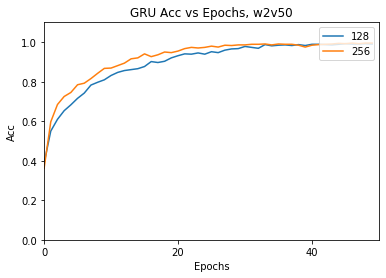

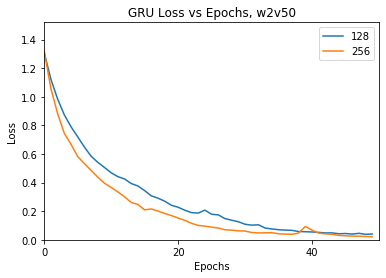

In [38]:
##Gráfico de Accuracy
graphic_data(np.arange(0,epochs,20),data_final_acc_w2v50,units_final,'GRU Acc vs Epochs, w2v50', 'Epochs', 'Acc',0,0,epochs,1+0.1)

##Gráfico de Loss 
max_loss_w2v50 = 0
for i in np.arange(0,len(data_final_loss_w2v50)):
    if(max(data_final_loss_w2v50[i]) > max_loss_w2v50):
        max_loss_w2v50 = max(data_final_loss_w2v50[i])
graphic_data(np.arange(0,epochs,20),data_final_loss_w2v50,units_final,'GRU Loss vs Epochs, w2v50', 'Epochs', 'Loss',
             0,0,epochs,max_loss_w2v50+0.2)

### Predicción: Modelo w2v50, LSTM

In [39]:
def predict_all_models(X_real, Y_real, models):
    j = 0
    all_predict = []
    counter_true =  collections.Counter(Y_real.argmax(1))
    for i in units_final:
        print("##### Predict, Units ", i,"#####")
        Y_predict_i=models[j].predict(X_real)
        counter_pred_i = collections.Counter(Y_predict_i.argmax(1))
        all_predict.append(Y_predict_i)
        print("predict: ",list(counter_pred_i.values()))
        print("Real   : ",list(counter_true.values()))
        j = j + 1
    return all_predict

In [40]:
all_predict_w2v50 = []
all_predict_w2v50 = predict_all_models(Xw2v50_full,Yw2v50_full,models_w2v50)

##### Predict, Units  128 #####
predict:  [187, 171, 185, 210]
Real   :  [188, 180, 180, 205]
##### Predict, Units  256 #####
predict:  [189, 174, 186, 204]
Real   :  [188, 180, 180, 205]


In [41]:
i = 0
for j in units_final:
    print("Units:", j, " - RMSE GRU w2v50:  ",mean_squared_error(Yw2v50_full, all_predict_w2v50[i])) #Y_true, Y_predict
    i = i + 1

Units: 128  - RMSE GRU w2v50:   0.017732516
Units: 256  - RMSE GRU w2v50:   0.01605857


#### Matriz Confusión: w2v50

Confusion matrix, without normalization
Confusion matrix, without normalization


<Figure size 360x360 with 0 Axes>

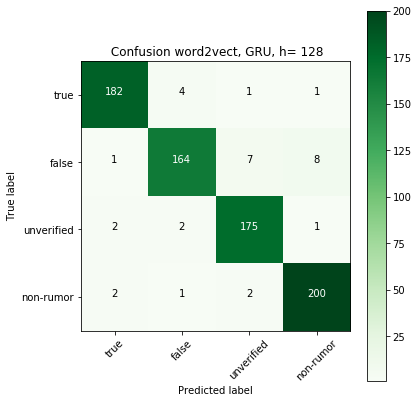

<Figure size 360x360 with 0 Axes>

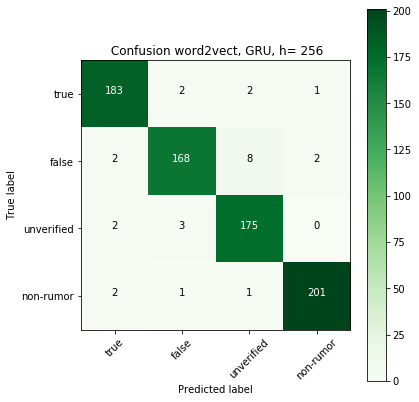

In [42]:
j = 0
for i in units_final:
    plot_conf_matrix(Yw2v50_full, all_predict_w2v50[j]," Confusion word2vect, GRU, h= " + str(i))
    j = j +1